<a href="https://colab.research.google.com/github/Kiwicodepedia/Exercise2/blob/main/Exercise_2_Euskera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [29]:
from google.colab import files
import unicodedata

# Subir archivos desde tu computadora
uploaded = files.upload()

# Obtener el nombre del archivo subido
file_name = list(uploaded.keys())[0]

# Decodificar el contenido del archivo
dataset = uploaded[file_name].decode("utf-8")

# Función para remover acentos
def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

# Dividir en líneas, limpiar cada una, quitar acentos y convertir a minúsculas
words = [remove_accents(line.strip().replace("\t", "").lower()) for line in dataset.split("\n") if line.strip()]

# Guardar el archivo limpio (opcional)
with open("archivo_limpio.txt", "w", encoding="utf-8") as file:
    file.write("\n".join(words))

# Mostrar los nombres limpios
print(words)

Saving Municipios Euskalherria.txt to Municipios Euskalherria (1).txt
['bilbao', 'astigarraga', 'agurain', 'barakaldo', 'santurtzi', 'aiara', 'bilar', 'abadino', 'alegria-', 'dulantzi', 'amurrio', 'anana', 'aramaio', 'vitoria-', 'gasteiz', 'san', 'sebastian', 'eibar', 'abanto', 'zierbena', 'aduna', 'abaltzisketa', 'arminon', 'ajangiz', 'alonsotegi', 'amorebieta-', 'etxano', 'aia', 'aizarnazabal', 'albiztur', 'arraia-', 'maeztu', 'arrazua-', 'ubarrundia', 'artziniega', 'amoroto', 'arakaldo', 'arantzazu', 'alegia', 'alkiza', 'altzaga', 'asparrena', 'manueta', 'areatza', 'arrankudiaga', 'arratzu', 'altzo', 'amezketa', 'andoain', 'barrundia', 'berantevilla', 'bernedo', 'arrieta', 'arrigorriaga', 'artea', 'anoeta', 'antzuola', 'arama', 'kanpezu', 'burgelu', 'elciego', 'artzentales', 'atxondo', 'aulesti', 'aretxabaleta', 'mondragon', 'asteasu', 'valle de', 'arana', 'iruna oka', 'bakio', 'ataun', 'balmaseda', 'azkoitia', 'azpeitia', 'iruraiz-', 'gauna', 'beasain', 'labastida', 'laguardia', 'k

In [30]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [32]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([1883, 3]) torch.Size([1883])
torch.Size([242, 3]) torch.Size([242])
torch.Size([255, 3]) torch.Size([255])


In [33]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([1883, 3]), torch.Size([1883]))

In [63]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [64]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [65]:
for p in parameters:
  p.requires_grad = True


In [66]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [67]:
lri = []
lossi = []
stepi = []

for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.105400562286377


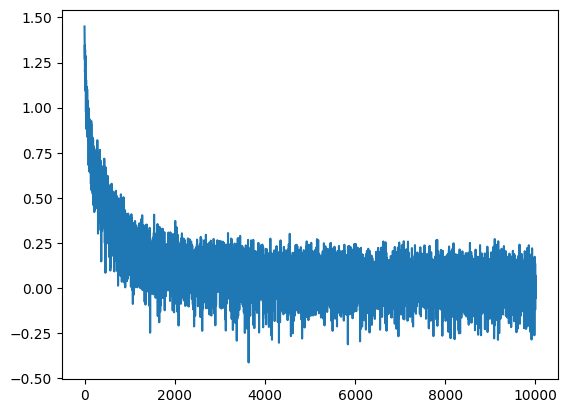

In [68]:
plt.plot(stepi, lossi)

In [69]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.0889, grad_fn=<NllLossBackward0>)

In [70]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(5.5106, grad_fn=<NllLossBackward0>)

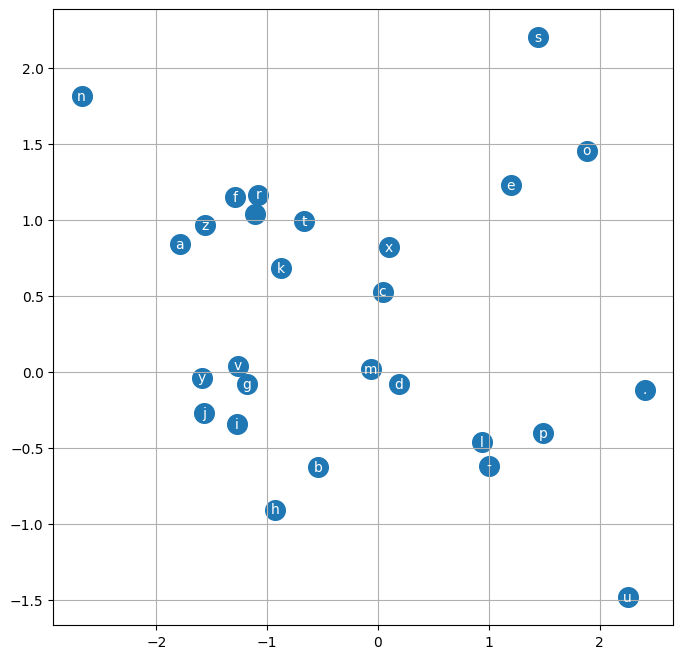

In [71]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [72]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [74]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

zalta.
kripan.
carri.
lasain.
sukarrieta.
zambranza.
jatauna.
mutrika.
larroa.
plentzisketaridanieta.
erretxo.
sama.
placencia de.
dima.
isparrietariz.
iruraizturiatzaga-.
laudio.
oyon-oion.
orozko.
plentevillaburueta.
